# 通过PYNQ加速OPENCV函数(Sobel算子)

在阅读本部分UserGuide时,请确认已做好以下准备：
* 已经按照之前的预备文档安装好依赖环境<br>
* 2根HDMI传输线(对输入视频流以及输出视频流进行测试)
* 一台支持HDMI的显示器(对输入视频流以及输出视频流进行测试)

## 步骤1：加载cv2pynq库

In [1]:
import cv2pynq as cv2

在正常运行的情况下,可以看到PYNQ板卡标记为“DONE”的LED闪烁(为加载了bit文件的效果);   
这是由于在封装的时候,我们在初始化阶段调用了Overlay方法给PYNQ加载了定制的bit文件:

```python
def __init__(self, load_overlay=True):     
    self.bitstream_name = None  
    self.bitstream_name = "cv2pynq03.bit"  
    self.bitstream_path =os.path.join(CV2PYNQ_BIT_DIR,self.bitstream_name)
    self.ol = Overlay(self.bitstream_path)
```

上述代码为cv2pynq.py的部分节选，从当中可以看出在初始化的过程中,加载了cv2pynq03.bit，  
因此在导入库的时候会出现加载bit文件的效果。加载的bit文件的Block Design如下图所示:

![Image1](../image/1.png)

这个Block Design主要由以下三个部分组成：
* HDMI输入输出模块（移植于BaseOverlay）
* 由Vivado HLS生成的OPENCV算法加速IP核（内嵌于Image_Fliter模块）
* 基于AXI总线架构的流传输通道

## 步骤2：对单张图像的处理效果测试

### 步骤2.1：采用原始的OpenCV中的Sobel算子对输入图像进行处理

在进行原始处理效果测试前，我们需要导入以下模块
* 导入原始的OPENCV
* 导入time模块计算处理的时间
* 导入Pillow模块用于读取图像
* 导入numpy模块将jpeg格式的图片转化为数组形式

Frames per second using openCV:  9.709522513162694


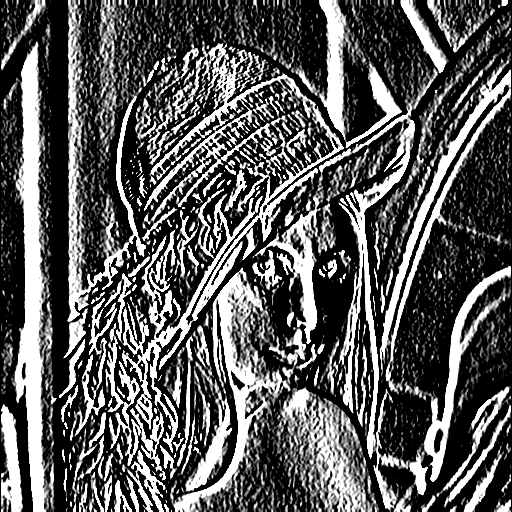

In [2]:
import cv2 as openCV
import time
from PIL import Image
import numpy as np

frame_in = Image.open('../image/lena.jpg')
img_in = np.array(frame_in)

fps_opencv = 0
fps_cv2pynq_with_cma = 0
fps_cv2pynq_without_cma = 0

start = time.time()
for i in range(10):
    out_opencv = openCV.Sobel(img_in,-1,1,0,ksize=5)#使用OpenCV对图像进行处理
end = time.time()


img_opencv = Image.fromarray(out_opencv.astype('uint8'))
fps_opencv = 1.0/((end - start)/10)
print("Frames per second using openCV:  " + str(fps_opencv))

img_opencv

### 步骤2.2：采用cv2pynq中的Sobel算子对输入图像进行处理

Frames per second using cv2pynq without cma:  85.59472183731651


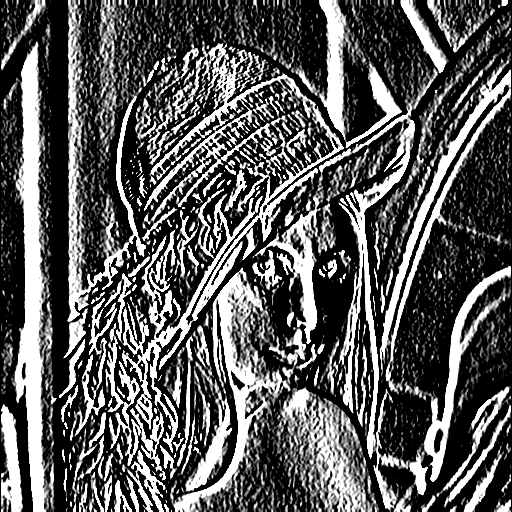

In [3]:
start = time.time()
for i in range(10):
    out_cv2pynq1 = cv2.Sobel(img_in,-1,1,0,ksize=5)#使用OpenCV对图像进行处理
end = time.time()


img_cv2pynq_0 = Image.fromarray(out_cv2pynq1.astype('uint8'))
fps_cv2pynq_without_cma = 1.0/((end - start)/10)
print("Frames per second using cv2pynq without cma:  " + str(fps_cv2pynq_without_cma))

img_cv2pynq_0

#### CMA&cv2pynq

CMA(Contiguous Memory Allocator)是智能连续内存分配技术，是Linux Kernel内存管理系统的扩展，目的在于解决需要预留大量连续内存导致运行内存紧张的问题。通过对内存的连续分配，cv2pynq可以将图片数据以流的形式传输给PL端，提高图像处理的速率；在PYNQ的原生库中提供了Xlnk类用来分配连续的内存空间，对Xlnk的更多了解，可参考：<br>
https://pynq-testing.readthedocs.io/en/master/pynq_libraries/xlnk.html

Frames per second using cv2PYNQ:  414.97768939281514


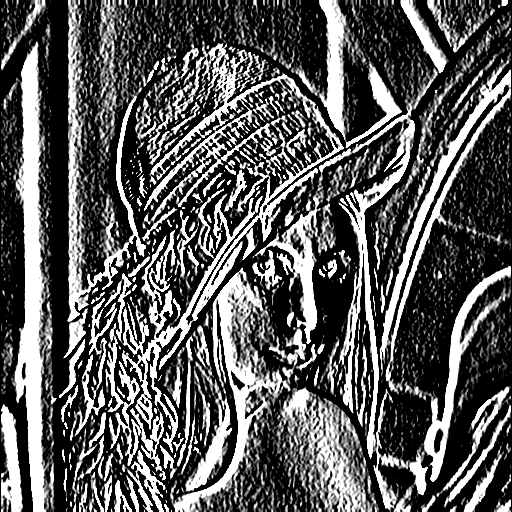

In [4]:
from pynq import Xlnk
xlnk = Xlnk()

image_buffer  = xlnk.cma_array(shape=(512,512), dtype=np.uint8)
out_buffer = xlnk.cma_array(shape=(512,512), dtype=np.uint8)

np.copyto(image_buffer,img_in)

start = time.time()
for i in range(10):
    cv2.Sobel(image_buffer,-1,1,0,ksize=5,dst=out_buffer)
end = time.time()

img_cv2pynq_1 = Image.fromarray(out_buffer.astype('uint8'))
fps_cv2pynq = 1.0/((end - start)/10)

print("Frames per second using cv2PYNQ:  " + str(fps_cv2pynq))
image_buffer.close()
out_buffer.close()
img_cv2pynq_1

## 步骤3：对视频流处理的效果显示

### 步骤3.1：实例化HDMI输入输出接口

在进行cv2pynq的视频流测试之前,我们需要引入视频流，<br>此处由Block Design中设置好的HDMI输入模块传入视频以及输出模块输出经过处理好的视频流信息;<br>关于HDMI输入输出的更多详情，可以参考BaseOverlay中的Video模块;<br>https://github.com/Xilinx/PYNQ/tree/master/boards/Pynq-Z2/base/notebooks/video
<br>https://github.com/Xilinx/PYNQ/tree/master/boards/Pynq-Z1/base/notebooks/video

In [5]:
hdmi_in = cv2.video.hdmi_in
hdmi_out = cv2.video.hdmi_out

hdmi_in.configure(cv2.PIXEL_GRAY)
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

print(hdmi_in.mode)

VideoMode: width=1920 height=1080 bpp=8


在正确的输入视频流信息之后，我们可以得到输入视频流的配置信息；<br>在本实验中,最大支持 1920 * 1080的输入信号。

### 步骤3.2：采用原始的OpenCV中的Sobel算子对输入信号进行处理

In [6]:
iterations = 10

start = time.time()
for i in range(iterations):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    openCV.Sobel(inframe,-1,1,0,ksize=5,dst=outframe)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
end = time.time()
print("Frames per second using OpenCV:  " + str(iterations / (end - start)))

Frames per second using OpenCV:  3.30869452274042


### 步骤3.3：采用cv2pynq中的Sobel算子对输入信号进行处理

In [7]:
import time

iterations = 10

start = time.time()
for i in range(iterations):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    cv2.Sobel(inframe,-1,1,0,ksize=5,dst=outframe)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
end = time.time()
print("Frames per second using cv2PYNQ:  " + str(iterations / (end - start)))

Frames per second using cv2PYNQ:  27.808357682115297


### 步骤3.4：释放HDMI驱动

In [8]:
hdmi_out.close()
hdmi_in.close()

### 步骤3.5：关闭cv2pynq

关闭cv2pynq是一个很重要的步骤，因为在BaseOverlay中的video子系统模块中，图片是以连续的内存数组（contiguous memory arrays）作为存储形式，因此在调用cv2pynq时，可以直接将数据以流的形式传输到PL端。所以避免cv2pynq一直占用连续的内存，必须关于cv2pynq以释放内存，而对连续的内存分配是基于PYNQ的Xlnk库，关于Xlnk的更多详情，可参考：<br>https://pynq.readthedocs.io/en/latest/pynq_libraries/xlnk.html

In [9]:
cv2.close()

## 附录：PL端是如何加速OPENCV函数处理的

在此项目中式采用一种基于Vivado HLS加速OpenCV程序的方法:<br>其核心是利用Xilinx高层次综合工具Vivado HLS，将C++编写的OpenCV程序按照Vivado HLS处理规范进行修改，进而将代码转换为硬件描述语言，可快速生成IP核。结合Xilinx PYNQ SoC架构,在顶层可直接对我们的Block Design进行Python式的封装，实现OpenCV程序算法向SoC系统的移植和加速。<br>

![Image of HLS](../image/2.png)

#### Sobel算子概述

Sobel算子是像素图像边缘检测中最重要的算子之一，在机器学习、数字媒体、计算机视觉等信息科技领域起着举足轻重的作用。在技术上，它是一个离散的一阶差分算子，用来计算图像亮度函数的一阶梯度之近似值。在图像的任何一点使用此算子，将会产生该点对应的梯度矢量或是其法矢量。

#### Sobel算子核心公式(ksize=3)

该算子包含两组3x3的矩阵（当ksize=3时），分别为横向及纵向，将之与图像作平面卷积，即可分别得出横向及纵向的亮度差分近似值。如果以A代表原始图像，Gx及Gy分别代表经横向及纵向边缘检测的图像，其公式如下:

$G_{x}=\begin{bmatrix}
+1&0&-1\\
+2&0&-2\\
+1&0&-1\\
\end{bmatrix}*A$   and 
$G_{y}=\begin{bmatrix}
+1&+2&+1\\
0&0&0\\
-1&-2&-1\\
\end{bmatrix}*A$

图像的每一个像素的横向及纵向梯度近似值可用以下的公式结合，来计算梯度的大小。 

$G = \sqrt[2]{G_x^2+G_y^2}$

然后可用以下公式计算梯度方向：

$\Theta=arctan(\frac{G_y}{G_x})$

更多关于Sobel算子的详细信息，可参考：<br>https://docs.opencv.org/3.0-beta/doc/tutorials/imgproc/imgtrans/sobel_derivatives/sobel_derivatives.html

#### 在Vivado HLS中映射Sobel算子的结构

在OpenCV中，通过传入dx与dy来求X方向的梯度以及Y方向的梯度从而输出不同方向上的处理结果，
而在从工程中，通过Vivado HLS建立了一个可通用性的卷积核矩阵IP核(fliter2D)，其通过接受PS的传输参数来控制卷积核的参数

```python
def Sobel(self,src, ddepth, dx, dy, dst, ksize):
            if(ksize == 3):
                self.f2D.rows = src.shape[0]
                self.f2D.columns = src.shape[1]
                self.f2D.channels = 1
                if (dx == 1) and (dy == 0) :
                    if self.filter2DType != 0 :
                        self.filter2DType = 0
                        self.f2D.r1 = 0x000100ff #[-1  0  1]
                        self.f2D.r2 = 0x000200fe #[-2  0  2]
                        self.f2D.r3 = 0x000100ff #[-1  0  1]
```

上述代码为顶层Python封装时对Sobel函数的部分描述，从中可以获得信息：<br>顶层通过传递dx与dy的值，设置好卷积核的参数，传入IP核（fliter2D）中，此处可看出在dx=1,dy=0时(即Sobel算子在X方向的卷积核)与上面对Sobel算子的描述是相同的，下述代码为在Vivado HLS中对IP核的部分描述：

```C
#include "filter2D_hls.h"
void filter2D_hls(wide_stream* in_stream, wide_stream* out_stream, int rows, int cols, int channels, int mode, ap_uint<32> r1, ap_uint<32> r2, ap_uint<32> r3) {
    #pragma HLS INTERFACE axis port *
    #pragma HLS INTERFACE s_axilite *
    #pragma HLS INTERFACE ap_stable *
    #pragma HLS dataflow
    
	GRAY_IMAGE g_img_0(rows,cols);
	GRAY_IMAGE g_img_1(rows,cols);
	const int col_packets = cols*channels/4;
	const int packets = col_packets*rows;
	const int pixel_cnt = rows*cols;

	for(int r = 0; r < packets; r++){
        #pragma HLS pipeline II=4
		ap_uint<32> dat = in_stream->data;
		g_img_0.write(GRAY_PIXEL(dat.range(7,0)));
		++in_stream;
	}

	const int kernel_size = 3;
	hls::Window<kernel_size,kernel_size,ap_int<8> >	kernel;

	kernel.val[0][0] = r1.range(7,0);

	hls::Point_<int> c_point;
	c_point.x=-1;
	c_point.y=-1;
	hls::Filter2D<hls::BORDER_DEFAULT>(g_img_0,g_img_1,kernel, c_point);


	for(int r = 0; r < rows; r++){
        #pragma HLS pipeline II=4
		for(int c = 0; c < col_packets; c++){
			ap_uint<32> dat;
			dat.range(7,0) = g_img_1.read().val[0];;
			out_stream->data = dat;
			out_stream->user = (r == 0 && c == 0)? 1: 0;
			out_stream->last = (r == rows-1 && c == col_packets-1)? 1: 0;
			++out_stream;
		}
	}
}
```

从Vivado HLS中对IP核的部分描述中，可以得到以下信息：<br>
* 将输入的信息用g_img_0来存储
* 根据PS端传入的r1,r2,r3参数设置卷积核
* 将g_img_0与设置好的卷积核(kernel)进行卷积，卷积结果输出给g_img_1
* 将输出结果赋予out_stream

上述过程简要的描述了Sobel算子在(ksize = 3)的情况下，如何在HLS中编写相应的算法从而生成IP核，并且在上层用Python对IP核进行封装的过程。<br>如要了解更多的关于OpenCV在HLS上的应用，可以参考XAP1167。<br>如需对本UserGuide中的源码有更多的了解，可以参考：<br>https://github.com/xupsh/cv2pynq/blob/XUP/cv2pynq/cv2pynq.py<br>
https://github.com/xupsh/cv2PYNQ-The-project-behind-the-library/blob/master/ip/HLS/filter2D/filter2D_hls.cpp